In [1]:
from Functions import *
from DataDefined import *
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim

In [31]:
df = pd.read_csv('Driving Data(KIA SOUL)_(150728-160714)_(10 Drivers_A-J).csv')

df, label_mappings = preprocessing(df, one_val_col, irrelevant_col, to_be_scaled_col, two_val_col, some_val_num_col, some_val_cat_col)

In [32]:
encoder = LabelEncoder()
df['Class'] = encoder.fit_transform(df['Class'])
print(encoder.classes_, encoder.transform(encoder.classes_))

#df = add_derivatives(df, delta_col)

['A' 'B' 'C' 'D' 'E' 'F' 'G' 'H' 'I' 'J'] [0 1 2 3 4 5 6 7 8 9]


In [33]:
class_features = ['Class', 'Ride number', 'Time(s)']
rel_class_features = relevant_features + class_features
df = df[rel_class_features]
df = add_derivatives(df, delta_col)
df.columns

Index(['Accelerator_Pedal_value', 'Vehicle_speed',
       'Acceleration_speed_-_Longitudinal', 'Acceleration_speed_-_Lateral',
       'Indication_of_brake_switch_ON/OFF', 'Steering_wheel_speed',
       'Steering_wheel_angle', 'Master_cylinder_pressure', 'Fuel_consumption',
       'Flywheel_torque', 'Class', 'Ride number', 'Time(s)',
       'Steering_wheel_speed_derivative', 'Accelerator_Pedal_value_derivative',
       'Vehicle_speed_derivative'],
      dtype='object')

In [10]:
from sklearn.utils import shuffle
from itertools import combinations


def get_next_index(i, j, size):
    new_index = j+i
    if new_index > (size-1):
        return new_index-(size-1)
    else:
        return new_index

def make_pairs_one_class(X, y, iterations, head):
    X = X.head(head).to_numpy()
    y = y.head(head).to_numpy()
    X_sameclass = []
    y_sameclass = []
    for i in range(0, iterations):
        for j in range(0, len(X)):
            index = get_next_index(i, j, len(X))
            X_sameclass.append(X[j] + X[index])
            y_sameclass.append(int(y[j] == y[index]))

    X_pairwise_shuffled, y_pairwise_shuffled = shuffle(X_sameclass, y_sameclass, random_state=42)


    return X_pairwise_shuffled, y_pairwise_shuffled

def create_pairs(X, source, head):
    """
    Function that creates pair vectors of samples in X, all combinations between samples in X are made. Pair vectors
    are made by concatenating two rows of X. The pair vectors are returned together with the labels, same_source (1) and 
    different_source (0). The label is same_source when source[sample_n] is the same as source[sample_p]; 
    if the sources are different, the label different_source is returned.
    
    return: numpy array X (features), numpy array y (labels)
    """
    # create all combinations for X and y
    X = [sample_1 + sample_2 for sample_1, sample_2 in combinations(X.head(head).to_numpy(), 2)]
    y = [int(group_1 == group_2) for group_1, group_2 in combinations(source.head(head).to_numpy(), 2)]

    X_shuffled, y_shuffled = shuffle(X, y, random_state=42)

    return np.array(X_shuffled), np.array(y_shuffled)

In [5]:
def splitDataForPairWise_ID(df, driver1, driver2, seed):
    df_driver1 = df[df['Class'] == driver1].copy(deep=True)
    df_driver2 = df[df['Class'] == driver2].copy(deep=True)

    ride_counts1 = df_driver1['Ride number'].unique().tolist()
    ride_counts2 = df_driver2['Ride number'].unique().tolist()
    ride_nr = []

    for i in range(0, 4):
        if i%2 == 0: #driver1
            randomGen = random.Random(i*seed)
            drive_nr = randomGen.sample(ride_counts1, 1)
            ride_nr.append(drive_nr[0])
            ride_counts1.pop(drive_nr[0])
        else: # driver2
            randomGen = random.Random(i*seed)
            drive_nr = randomGen.sample(ride_counts2, 1)
            ride_nr.append(drive_nr[0])
            ride_counts2.pop(drive_nr[0])

    ## create test set
    df_test1 = df_driver1[df_driver1['Ride number'] == ride_nr[0]]
    df_test2 = df_driver2[df_driver2['Ride number'] == ride_nr[1]]
    df_test = pd.concat([df_test1, df_test2])

    ## create validation set
    df_val1 = df_driver1[df_driver1['Ride number'] == ride_nr[2]]
    df_val2 = df_driver2[df_driver2['Ride number'] == ride_nr[3]]
    df_val = pd.concat([df_val1, df_val2])

    ## create training set
    df_train1 = df_driver1[df_driver1['Ride number'].isin(ride_counts1)]
    df_train2 = df_driver2[df_driver2['Ride number'].isin(ride_counts2)]
    df_train = pd.concat([df_train1, df_train2])

    ### Shuffle all of the datasets
    df_test = df_test.sample(frac = 1, random_state=seed)
    df_val = df_val.sample(frac = 1, random_state=seed)
    df_train = df_train.sample(frac = 1, random_state=seed)


    ## split df up into X and y
    X_train, y_train = split_into_X_and_y(df_train)
    X_test, y_test = split_into_X_and_y(df_test)
    X_val, y_val = split_into_X_and_y(df_val)

    return X_train, y_train, X_test, y_test, X_val, y_val

In [ ]:
X_train, y_train, X_test, y_test, X_val, y_val = splitDataForPairWise_ID(df, 1, 3, 42)

X_train_pairs, y_train_pairs = create_pairs(X_train, y_train, 600)
X_test_pairs, y_test_pairs = create_pairs(X_test, y_test, 200)
X_val_pairs, y_val_pairs = create_pairs(X_val, y_val, 200)

In [35]:
print(len(X_train_pairs), len(y_train_pairs))
print(len(X_test_pairs), len(y_test_pairs))
print(len(X_val_pairs), len(y_val_pairs))

179700 179700
19900 19900
19900 19900


### Model Training

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier




scorer_gbc = GradientBoostingClassifier(n_estimators=300)

scorer_lr = LogisticRegression()

scorer_knn = KNeighborsClassifier()



# first we initialize a random forest instance
scorer = RandomForestClassifier()

# then we call the fit method of the model to fit it to our data
scorer_knn.fit(X_train_pairs, y_train_pairs)

KNeighborsClassifier()

In [ ]:
# we can feed our model the train pairs to make predictions on these samples
train_predictions = scorer_knn.predict(X_train_pairs)

# calculate the percentage of correct predictions
print(f'Percentage correctly predicted: {np.mean(train_predictions == y_train_pairs)*100}%')

Percentage correctly predicted: 81.9574311023622%


In [ ]:
# we can feed our model the train pairs to make predictions on these samples
test_predictions = scorer_knn.predict(X_test_pairs)

# calculate the percentage of correct predictions
print(f'Percentage correctly predicted: {np.mean(test_predictions == y_test_pairs)*100}%')

Percentage correctly predicted: 59.168808911739504%


In [ ]:
scores = scorer_knn.predict_proba(X_test_pairs)

print('The first five predictions of the model:')
print(scores[:5])

The first five predictions of the model:
[[0.4 0.6]
 [1.  0. ]
 [0.6 0.4]
 [0.6 0.4]
 [0.2 0.8]]


In [ ]:
# save the scores for Hp and Hd as our probabilities
P_Hp_test = scores[:, 1]
P_Hd_test = scores[:, 0]

# now divide these scores to get LRs
LRs_test = P_Hp_test/P_Hd_test

print(LRs_test)

[1.5        0.         0.66666667 ... 0.66666667 0.                inf]


C:\Users\miria\AppData\Local\Temp\ipykernel_10676\850387025.py:6: RuntimeWarning: divide by zero encountered in divide
  LRs_test = P_Hp_test/P_Hd_test


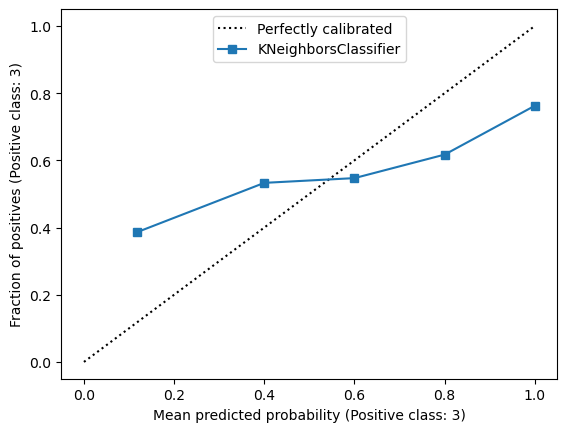

In [66]:
from sklearn.calibration import CalibrationDisplay
import matplotlib.pyplot as plt

# for the calibration curve we need the probabilities P_Hp and the labels
disp= CalibrationDisplay.from_estimator(scorer_knn, X_test, y_test, n_bins=5)

# we will move the legend so it is not clashing with the line
plt.legend(loc='upper center')


In [67]:
from lir.metrics import cllr

print(f'The Cllr for our uncalibrated system: {cllr(LRs_test, y_test)}')

The Cllr for our uncalibrated system: nan


c:\Users\miria\anaconda3\Lib\site-packages\numpy\core\fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
c:\Users\miria\anaconda3\Lib\site-packages\numpy\core\_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


In [48]:
from lir.calibration import LogitCalibrator

# 1: we calculate the scores on the train data
P_Hp_train = scorer_gbc.predict_proba(X_train_pairs)[:, 1]

# 2: we make a calibration instance
calibrator = LogitCalibrator()

# 3: fit the calibrator
calibrator.fit(P_Hp_train, y_train_pairs)

# 4: we use the calibrator to calibrate our uncalibrated scores 
calibrated_LRs_test = calibrator.transform(P_Hp_test)

print(f'The Cllr for our calibrated system: {cllr(calibrated_LRs_test, y_test_pairs)}')

The Cllr for our calibrated system: 1.0414591165309595


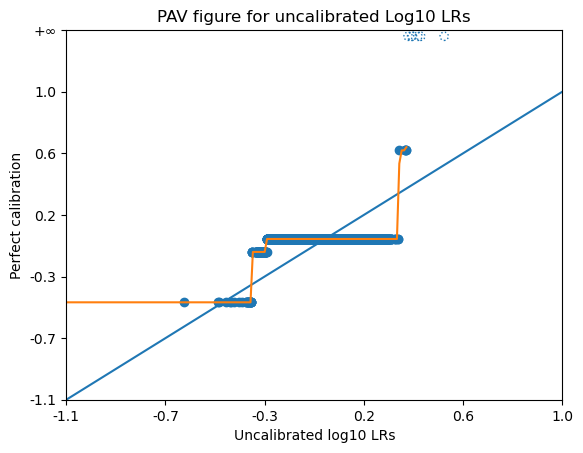

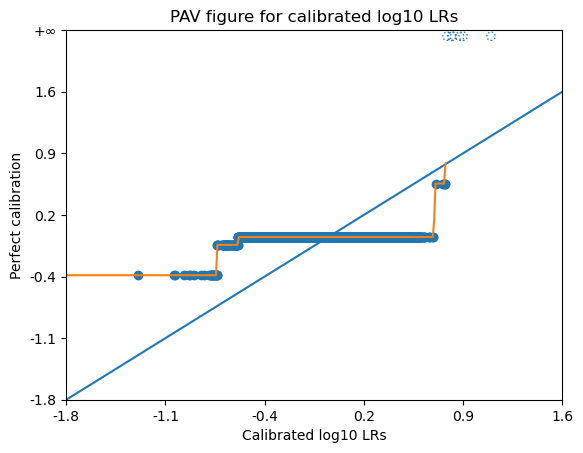

In [49]:
from lir import plotting

# PAV for uncalibrated LRs
with plotting.show() as ax:
    ax.pav(LRs_test, y_test_pairs)
    ax.xlabel('Uncalibrated log10 LRs')
    ax.ylabel('Perfect calibration')
    ax.title('PAV figure for uncalibrated Log10 LRs')
    
# PAV for calibrated LRs
with plotting.show() as ax:
    ax.pav(calibrated_LRs_test, y_test_pairs)
    ax.xlabel('Calibrated log10 LRs')
    ax.ylabel('Perfect calibration')
    ax.title('PAV figure for calibrated log10 LRs')